In [29]:
import torch
from matplotlib import pyplot as plt

checkpoint = torch.load('models/just_pitches')

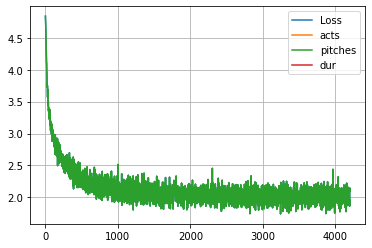

In [30]:
losses = checkpoint['losses']

plt.plot(range(1, len(losses['tot'])+1), losses['tot'], label='Loss')
plt.plot(range(1, len(losses['acts'])+1), losses['acts'], label='acts')
plt.plot(range(1, len(losses['pitches'])+1), losses['pitches'], label='pitches')
plt.plot(range(1, len(losses['dur'])+1), losses['dur'], label='dur')
#plt.plot(range(1, len(losses['kld'])+1), losses['kld'], label='kld')
plt.grid()
plt.legend()

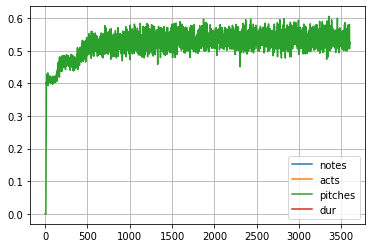

In [23]:
accs = checkpoint['accuracies']
plt.plot(range(1, len(accs['notes'])+1), accs['notes'], label='notes')
plt.plot(range(1, len(accs['acts'])+1), accs['acts'], label='acts')
plt.plot(range(1, len(accs['pitches'])+1), accs['pitches'], label='pitches')
plt.plot(range(1, len(accs['dur'])+1), accs['dur'], label='dur')
plt.grid()
plt.legend()

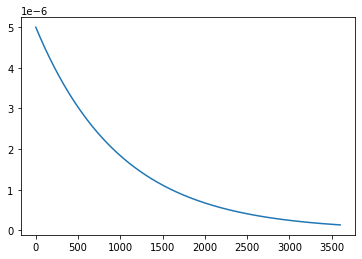

In [27]:
lrs = checkpoint['lrs']
plt.plot(range(1, len(lrs)+1), lrs, label='Lr')

In [28]:
lrs[-1]

1.363727561536152e-07